# Задание 1

## Подготовка и первичный анализ данных

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [ ]:
df = pd.read_csv('/content/titanic_train.csv')

Найдем количество пропущенных значений поля `age`.

In [ ]:
df['age'].isna().sum()

199

Вычислим долю выживших.

In [ ]:
len(df[df['survived'] == 1])/len(df)

0.382262996941896

Удалим колонку `ticket`, а так же те признаки, где доля пропусков больше трети.

In [ ]:
df_droped = df.drop('ticket', axis=1)
for col in df_droped.columns:
  if df_droped[col].isna().sum()/len(df_droped[col]) > 1/3:
    df_droped = df_droped.drop(col, axis=1)

Из описания набора данных видно, что колонки `sibsp` и `parch` по сути отвечают за размер семьи. Заменим эти две колонки на колонку `fam_size`, значения которой будут вычисляться как сумма соответствующих значений в колонках `sibsp` и `parch`.

In [ ]:
df_droped['fam_size'] = df_droped['sibsp'] + df_droped['parch']
df_droped = df_droped.drop(['sibsp', 'parch'], axis=1)
df_droped['fam_size'].mean()

0.8664627930682977

Выборочное среднее нового признака - 0.8664627930682977.

In [ ]:
X = df_droped.drop('survived', axis=1)
len(X.columns)

7

Таким образом, полученное число предикторов - 7.

In [ ]:
df_droped[(df_droped['sex'] =='female') & (df_droped['pclass'] == 1)]['survived'].mean()

0.9711538461538461

Вероятность выжить женщине из 1 класса довольно высока - 0.9711538461538461.

Построим гистограммы выжиших и невыживших по возрастам.

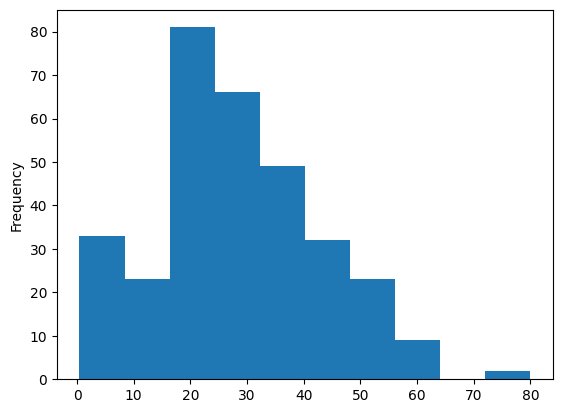

In [ ]:
df_droped[df_droped['survived'] == 1]['age'].plot.hist()
plt.show()

##Модель на основе числовых признаков

### Удаление строк с пропусками

В качестве базовой модели имеет смысл построить модель с минимальными трудозатратами.

Из исходного датасета удалим все категориальные признаки, а также строки, содержащие пропуски. Разобьем набор данных на обучающую и тестовую выборки Обучим модель на тренировочных данных и оценим на тестовых при помощи `f1_score`.

In [ ]:
df_cleared = df_droped.select_dtypes(include='number').dropna()
X_cleared = df_cleared.drop('survived', axis=1)
y = df_cleared[['survived']]
X_train, X_test, y_train, y_test = train_test_split(X_cleared, y, test_size=0.2, random_state=11, stratify=y)

log = LogisticRegression(random_state=11, max_iter=1000)
log.fit(X_train, y_train)
f1_score(y_test, log.predict(X_test))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5471698113207547

### Заполнение пропусков средним

Качество полученной модели оставляет желать лучшего. Имеет смысл попробовать заполнить пропуски. Из исходного набора данных удалим категориальные признаки, а пропуски заполните средним по столбцу.

In [ ]:
df_filled = df_droped.select_dtypes(include='number').fillna(df_droped.select_dtypes(include='number').mean())
X = df_filled.drop('survived', axis=1)
y = df_filled[['survived']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, stratify=y)

log = LogisticRegression(random_state=11, max_iter=1000)
log.fit(X_train, y_train)
f1_score(y_test, log.predict(X_test))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.4297520661157025

### Заполнение пропусков на основе обращения


Очевидно, что заполнение пропусков в колонке `age` средним — не самая разумная идея. Возможно, стоит выполнить эту процедуру как-то более интеллектуально, например, с оглядкой на обращение к человеку.

Можно заметить, что исходный датасет в столбце `name` содержит информацию о социальном статусе пассажира, а именно присутсвуют обращения `Mr., Mrs., Dr.`и т.д. На основе этой информации можно попробовать сделать предположение о возрасте пассажира.

Вернем в рассмотрение колонку `name`. Создадим отдельную колонку `honorific` и поместим туда значения обращений.

In [ ]:
df_cat = df_droped.select_dtypes(include='number')
df_cat['honorific'] = df_droped['name'].str.split(',').str[1].str.split('.').str[0].str.strip()
len(df_cat['honorific'].unique())

14

Мы получили 14 уникальных обращений. Скорее всего имеет смысл сократить число обращений.

Выполним замены:

`Mr` $\leftarrow$ `['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt']`

`Mrs` $\leftarrow$ `['Dona', 'Countess']`

`Miss` $\leftarrow$ `['Mlle', 'Ms']`

In [ ]:
df_cat['honorific'] = df_cat['honorific'].apply(lambda x: 'Mr' if x in ['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt'] else 'Mrs' if x in ['Dona', 'Countess'] else 'Miss' if x in ['Mlle', 'Ms'] else x)

In [ ]:
len(df_cat[df_cat['honorific'] == 'Master'])/len(df[df['sex'] == 'male'])

0.07232704402515723

Относительно числа всех мужчин доля строк со значением `Master` составляет 0.07232704402515723.

In [ ]:
df_cat[df_cat['honorific'] == 'Miss']['age'].mean()

22.00576540880503

Средний возраст категории `Miss` составляет 22 года.

Заполним пропуски в колонке `age` средним, соответствующим среднему категории `honorific`.

In [ ]:
honorific_age_mean = df_cat.groupby('honorific')['age'].mean().to_dict()
df_cat['age'] = df_cat['age'].fillna(df_cat['honorific'].map(honorific_age_mean))

Вычислим `f1_score` модели на тестовых данных.

In [ ]:
X = df_cat.drop(['survived', 'honorific'], axis=1)
y = df_cat[['survived']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, stratify=y)

log = LogisticRegression(random_state=11, max_iter=1000)
log.fit(X_train, y_train)
f1_score(y_test, log.predict(X_test))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.43902439024390244

## Модель с использование категориальных признаков

Произведем one-hot кодировние нечисловых признаков с помощью `pd.get_dummies(drop_first=True)`. Вычислим `f1_score` модели на тестовых данных.

In [ ]:
df_num = df_cat.drop(['survived', 'honorific'], axis=1)

In [ ]:
df_cat_encoded = df_droped.select_dtypes(exclude='number').drop(['name'], axis=1)
df_cat_encoded = pd.get_dummies(df_cat_encoded, columns=df_cat_encoded.columns, drop_first=True)

In [ ]:
X = pd.concat([df_num, df_cat_encoded], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, stratify=y)

log = LogisticRegression(random_state=11, max_iter=1000)
log.fit(X_train, y_train)
f1_score(y_test, log.predict(X_test))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6575342465753424

#Задание 2

Используя весь датасет из предыдущего задания как обучающий, выполним предсказания для зарезервированного набора данных. Для успешного выполнения задания необходимо, чтобы результат превысил пороговое значение, равное 0.74. В качестве метрики используется f1_score.

In [73]:
df = pd.read_csv('/content/titanic_train.csv')
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q,NaN
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q,"Co Clare, Ireland Washington, DC"
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,2688,7.2292,NaN,C,NaN
3,3,0,"Vovk, Mr. Janko",male,22.0,0,0,349252,7.8958,NaN,S,NaN
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,345778,9.5000,NaN,S,NaN


In [74]:
X_train = df.drop(['survived'], axis=1)
y_train = df[['survived']]

Как и в предыдущем задании, выделим новый признак `fam_size`. Добавим булевый признак `alone`, принимающий истинное значение, если пассажир путешествовал один.

In [75]:
def find_fam_size_and_is_alone(df):
  df['fam_size'] = df['sibsp'] + df['parch']
  df['alone'] = 0
  df.loc[df['fam_size'] == 0, 'alone'] = 1

Заполним пропуски в колонке `age` средним на основе обращения. Вместо возраста пассажира в дальнейшем будет учитывать его принадлежность к определенной возрастной категории.

In [76]:
def find_age_category(df):
  df['honorific'] = df['name'].str.split(',').str[1].str.split('.').str[0].str.strip()
  df['honorific'] = df['honorific'].apply(lambda x: 'Mr' if x in ['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt'] else 'Mrs' if x in ['Dona', 'Countess'] else 'Miss' if x in ['Mlle', 'Ms'] else x)
  honorific_age_mean = df.groupby('honorific')['age'].mean().to_dict()
  df['age'] = df['age'].fillna(df['honorific'].map(honorific_age_mean))
  df['age_category'] = 0
  df.loc[df['age'] <= 16, 'age_category'] = 0
  df.loc[(df['age'] > 16) & (df['age'] <= 32), 'age_category'] = 1
  df.loc[(df['age'] > 32) & (df['age'] <= 48), 'age_category'] = 2
  df.loc[(df['age'] > 48) & (df['age'] <= 64), 'age_category'] = 3
  df.loc[df['age'] > 64, 'age_category'] = 4

Так же выделим категории на основе стоимости проезда пассажира.

In [77]:
def find_fare_category(df):
  df['fare_category'] = 0
  df.loc[df['fare'] <= 7.91, 'fare_category'] = 0
  df.loc[(df['fare'] > 7.91) & (df['fare'] <= 14.454), 'fare_category'] = 1
  df.loc[(df['fare'] > 14.454) & (df['fare'] <= 31), 'fare_category'] = 2
  df.loc[(df['fare'] > 31) & (df['fare'] <= 513), 'fare_category'] = 3

Удалим ненужные признаки.

In [78]:
def clear(df):
  df.drop(['sibsp', 'parch', 'name', 'age', 'ticket', 'fare', 'cabin', 'home.dest', 'honorific'], axis=1, inplace=True)

Применим все преобразования для тренировочного набора данных.

In [79]:
def transform_df(df):
  find_fam_size_and_is_alone(df)
  find_age_category(df)
  find_fare_category(df)
  clear(df)

In [80]:
transform_df(X_train)
X_train.head()

,pclass,sex,embarked,fam_size,alone,age_category,fare_category
0,3,female,Q,0,1,1,0
1,3,female,Q,0,1,1,0
2,3,female,C,0,1,2,0
3,3,male,S,0,1,1,0
4,3,male,S,0,1,0,1


Произведем one-hot кодировние нечисловых признаков.

In [81]:
def one_hot(df):
  cat = df.select_dtypes(exclude='number')
  num = df.select_dtypes(include='number')
  cat = pd.get_dummies(cat, columns=cat.columns, drop_first=True)
  return pd.concat([num, cat], axis=1)

In [82]:
X_train = one_hot(X_train)
X_train.head()

,pclass,fam_size,alone,age_category,fare_category,sex_male,embarked_Q,embarked_S
0,3,0,1,1,0,False,True,False
1,3,0,1,1,0,False,True,False
2,3,0,1,2,0,False,False,False
3,3,0,1,1,0,True,False,True
4,3,0,1,0,1,True,False,True


Выживших гораздо меньше, чем погибших. Сделаем распределение классов более равномерным, сохраняя структуру данных, сгенерировав новые примеры класса-меньшинства на основе близлежащих соседей.

In [83]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

Стандартизируем данные.

In [84]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

Построим модель.

In [86]:
log = LogisticRegression()
log.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

Все предыдущие шаги повторим для тестового набора данных.

In [87]:
X_test = pd.read_csv('/content/titanic_reserved.csv')
transform_df(X_test)
X_test = one_hot(X_test)
X_test_scaled = scaler.transform(X_test)

Выполним предсказания.

In [ ]:
y = log.predict(X_test_scaled)
y

array([0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,